In [ ]:
%%capture
!pip install bertopic hdbscan sentence-transformers

In [ ]:
import spacy

from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_20newsgroups

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction

[BERTopic repo](https://github.com/MaartenGr/BERTopic)

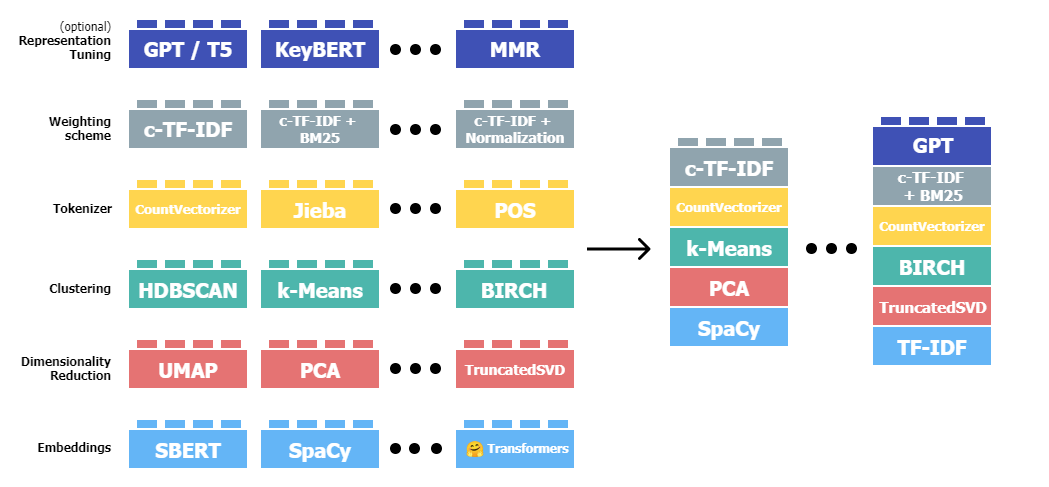

In [ ]:
docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']

### Построение эмбеддингов

По умолчанию `sentence-transformers`

In [ ]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# embedding_model = pipeline("feature-extraction", model="distilbert-base-cased")
# embedding_model = spacy.load("en_core_web_md", exclude=['tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer'])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Снижение размерности

По умолчанию `UMAP` - позволяет сохранить часть локальной и глобальной структуры набора данных при уменьшении его размерности.

In [ ]:
dim_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# dim_model = PCA(n_components=5)
# dim_model = TruncatedSVD(n_components=5)
# dim_model = BaseDimensionalityReduction()

### Кластеризация

По умолчанию `HDBSCAN` -  может находить кластеры различной формы и умеет выявлять выбросы

In [ ]:
cluster_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# cluster_model = KMeans(n_clusters=50)
# cluster_model = AgglomerativeClustering(n_clusters=50)

### Токенизация

При использовании HDBSCAN для кластеризации можно предположить, что кластеры имеют разные плотности и формы. Значит, представление тем на основе центроидов может быть не самым подходящим и нужен метод представления тем, который практически не делает предположений об ожидаемой структуре кластеров.

Для этого сначала все документы кластера объединяются в очень длинный один документ. Затем генерируюется «мешок слов» с частотами каждого слова в каждом кластере. Таким образом, это представление «мешка слов» на уровне кластера, а не на уровне документа.



In [ ]:
vectorizer_model = CountVectorizer(stop_words="english", min_df=5)

### Создание тем

Из сгенерированного «мешка слов» мы хотим знать, что отличает один кластер от другого.

Для этого можно использовать модифицированный `TF-IDF`

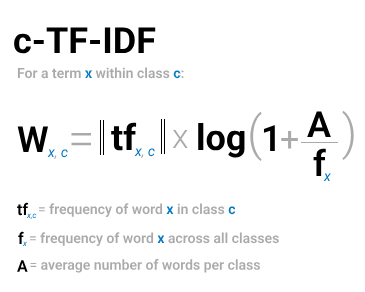

In [ ]:
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

### Fine-tuning

#### KeyBERTInspired

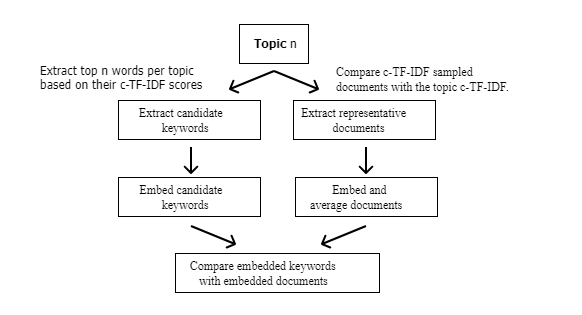

KeyBERT:

- С помощью BERT извлекаются эмбеддинги текстов.
- Затем для слов/фраз извлекаются эмбеддинги слов.
- Используя cosine similarity находятся слова/фразы, наиболее похожие на документ

In [ ]:
representation_model = KeyBERTInspired()

#### MaximalMarginalRelevance

Когда мы рассчитываем веса ключевых слов, мы обычно не учитываем, есть ли у нас уже похожие ключевые слова в теме.

Чтобы уменьшить избыточность и увеличить разнообразие ключевых слов, мы можем использовать MMR:

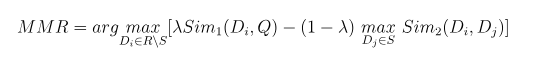

### Соберем все вместе

In [ ]:
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=dim_model,                     # Step 2 - Reduce dimensionality
  hdbscan_model=cluster_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model # Step 6 - (Optional) Fine-tune topic represenations
)

In [ ]:
%%time

topics, probs = topic_model.fit_transform(docs)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



CPU times: user 1min 45s, sys: 1.83 s, total: 1min 47s
Wall time: 1min 27s


In [ ]:
topic_model.get_topic_info()[1:11]

,Topic,Count,Name,Representation,Representative_Docs
1,0,1830,0_hockey_rangers_stats_score,"[hockey, rangers, stats, score, montreal, pens...",[Here are the final stats for the CHL for the ...
2,1,599,1_encryption_nsa_security_cryptographic,"[encryption, nsa, security, cryptographic, cry...",[Here is a revised version of my summary which...
3,2,525,2_huh___,"[huh, , , , , , , , , ]","[\nYep.\n, \n \n ..."
4,3,441,3_scsi_disks_disk_harddisk,"[scsi, disks, disk, harddisk, bios, toshiba, d...","[: >>point of view, why does SCSI have an adva..."
5,4,435,4_investigation_enforcement_murder_incident,"[investigation, enforcement, murder, incident,...","[Folks,\n\nIt's time to start building some pr..."
6,5,434,5_patients_physician_physicians_medicine,"[patients, physician, physicians, medicine, me...","[GREAT post Martin. Very informative, well-ba..."
7,6,369,6_firearms_firearm_militia_handgun,"[firearms, firearm, militia, handgun, amendmen...","[[Note, Ohio legislation unlike Federal legisl..."
8,7,316,7_newsgroup_newsletter_newsgroups_cdc,"[newsgroup, newsletter, newsgroups, cdc, org, ...",[Voting for creation of the newsgroup misc.hea...
9,8,195,8_motherboard_ram_amiga_4mb,"[motherboard, ram, amiga, 4mb, 2mb, mb, prices...",[I have the following computer items for sale:...
10,9,177,9_mazda_mustang_porsche_sedan,"[mazda, mustang, porsche, sedan, chassis, ford...","[\n\n*nnnnnnnng* Thank you for playing, I cann..."


### Визуализация распределения тем

In [ ]:
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, calculate_tokens=True, batch_size=100)

In [ ]:
topic_model.visualize_distribution(topic_distr[1])

In [ ]:
df = topic_model.visualize_approximate_distribution(docs[1], topic_token_distr[1])
df

,My,brother,is,in,the,market,for,high,performance,video,card,that,supports,VESA,local,bus,with,2MB,RAM,Does,anyone,have,suggestions,ideas,on,Diamond,Stealth,Pro,Local,Bus,Orchid,Farenheit,1280,ATI,Graphics,Ultra,Pro,Any,other,high,performance,VLB,card,Please,post,or,email,Thank,you,Matt
31_ram_simms_vram_simm,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.105,0.206,0.306,0.306,0.201,0.101,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
36_vga_drivers_cga_driver,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.105,0.215,0.327,0.327,0.323,0.213,0.102,0.102,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.134,0.285,0.441,0.549,0.415,0.264,0.108,0.000,0.000,0.000,0.113,0.113,0.113,0.113,0.000,0.000,0.000,0.000,0.104,0.104,0.104,0.104,0.000,0.000,0.000,0.000,0.000
55_processor_processors_cpus_cpu,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.106,0.106,0.106,0.106,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
120_vga_vram_card_benchmarks,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.149,0.312,0.439,0.540,0.392,0.228,0.101,0.121,0.256,0.377,0.498,0.377,0.242,0.121,0.000,0.000,0.117,0.232,0.357,0.474,0.507,0.560,0.589,0.668,0.665,0.654,0.642,0.447,0.300,0.143,0.000,0.127,0.296,0.477,0.633,0.622,0.453,0.272,0.116,0.000,0.000,0.000,0.000
128_vga_640x480_graphics_supervga,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.136,0.262,0.387,0.532,0.397,0.271,0.146,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
134_benchmarks_performance_benchmark_card,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.111,0.225,0.225,0.225,0.114,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.153,0.317,0.486,0.630,0.477,0.313,0.144,0.000,0.000,0.105,0.256,0.365,0.470,0.364,0.214,0.262,0.329,0.507,0.675,0.518,0.346,0.168,0.000,0.000,0.000,0.000,0.000
